In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv(r'/workspaces/Nursing-Home-Analysis/Master_Dataset_Cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   State                             51 non-null     object
 1   Number of Nursing Home Residents  51 non-null     int64 
 2   Number of Nursing Facilities      51 non-null     int64 
 3   Occupancy Rate                    51 non-null     object
 4   Total Number of Beds              51 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ KB


In [5]:
#creating the composite variable

#selecting only the integer columns
int_columns = df.select_dtypes(include=np.number).columns

#using the same weight for each column
df['Investment_Attractiveness_Score'] = np.sum(df[int_columns] * (1 / len(int_columns)), axis=1)

#using different weights for each column
weights = {'Total Number of Beds': 0.5, 'Number of Nursing Facilities': 0.3, 'Number of Nursing Home Residents': 0.2}

weighted_sum = np.sum(df[int_columns] * np.array([weights[col] for col in int_columns]), axis=1)
df['Investment_Attractiveness_Score_V2'] = weighted_sum

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['State_encoded'] = encoder.fit_transform(df['State'])

In [7]:
#removing outliers from first composite variable (with equal weights)
Q1 = df['Investment_Attractiveness_Score'].quantile(0.25)
Q3 = df['Investment_Attractiveness_Score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Investment_Attractiveness_Score'] >= lower_bound) & (df['Investment_Attractiveness_Score'] <= upper_bound)]

#removing outliers from first composite variable (with different weights)
Q1_V2 = df['Investment_Attractiveness_Score_V2'].quantile(0.25)
Q3_V2 = df['Investment_Attractiveness_Score_V2'].quantile(0.75)
IQR_V2 = Q3 - Q1

lower_bound_V2 = Q1_V2 - 1.5 * IQR_V2
upper_bound_V2 = Q3_V2 + 1.5 * IQR_V2

df = df[(df['Investment_Attractiveness_Score_V2'] >= lower_bound_V2) & (df['Investment_Attractiveness_Score_V2'] <= upper_bound_V2)]

print(df['Investment_Attractiveness_Score'].describe()) #after removing outliers
print(df['Investment_Attractiveness_Score_V2'].describe()) #after removing outliers

count       44.000000
mean     12561.681818
std       9747.603208
min        385.000000
25%       3829.833333
50%      11781.833333
75%      17798.333333
max      34875.666667
Name: Investment_Attractiveness_Score, dtype: float64
count       44.000000
mean     14650.959091
std      11777.308020
min        370.400000
25%       4318.050000
50%      13451.700000
75%      20500.850000
max      42990.400000
Name: Investment_Attractiveness_Score_V2, dtype: float64


In [8]:
#label encoding target values and identifying the top 20% of the data for each composite variable
df['Target_Investment_Score'] = df['Investment_Attractiveness_Score'] > df['Investment_Attractiveness_Score'].quantile(0.80)

label_dict = {True: 1, False: 0}

df['Target_Investment_Score'] = df['Target_Investment_Score'].map(label_dict)

#for the second composite variable
df['Target_Investment_Score_V2'] = df['Investment_Attractiveness_Score_V2'] > df['Investment_Attractiveness_Score_V2'].quantile(0.80)

label_dict_V2 = {True: 1, False: 0}
df['Target_Investment_Score_V2'] = df['Target_Investment_Score_V2'].map(label_dict_V2)

#results
print(df['Target_Investment_Score'].value_counts(1))
print(df['Target_Investment_Score_V2'].value_counts(1))

Target_Investment_Score
0    0.795455
1    0.204545
Name: proportion, dtype: float64
Target_Investment_Score_V2
0    0.795455
1    0.204545
Name: proportion, dtype: float64


In [9]:
X = df.drop(['State','Occupancy Rate', 'Investment_Attractiveness_Score', 'Target_Investment_Score', 'Target_Investment_Score_V2', 'Investment_Attractiveness_Score_V2'], axis=1)
y = df['Target_Investment_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
rf_grid = {'max_depth': [2,3,4,5,6],
           'min_samples_leaf': [0.015, 0.02, 0.025, 0.03, 0.035, 0.05],
           'n_estimators': [10, 50, 60, 100]}

rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_grid, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
print("Train Score", rf.score(X_train, y_train))
print("Test Score", rf.score(X_test, y_test))
print("Best Parameters", rf.best_params_)
print("Features", rf.best_estimator_.feature_importances_)

Train Score 1.0
Test Score 1.0
Best Parameters {'max_depth': 3, 'min_samples_leaf': 0.015, 'n_estimators': 60}
Features [0.38790193 0.10435684 0.50357146 0.00416977]


In [11]:
feature_names = X.columns
feature_importances = rf.best_estimator_.feature_importances_

for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")


Number of Nursing Home Residents: 0.3879019293605265
Number of Nursing Facilities: 0.10435684177736447
Total Number of Beds: 0.5035714610243769
State_encoded: 0.004169767837732246


In [12]:
new_df = df.select_dtypes(include=None, exclude='object')
new_df = new_df.drop(['Investment_Attractiveness_Score', 'Target_Investment_Score'], axis=1)
new_df

,Number of Nursing Home Residents,Number of Nursing Facilities,Total Number of Beds,Investment_Attractiveness_Score_V2,State_encoded,Target_Investment_Score_V2
0,18814,228,25751,16706.7,0,0
1,677,20,458,370.4,1,0
2,10200,145,17339,10753.0,2,0
3,14102,224,25538,15656.6,3,0
5,13522,224,21777,13660.1,5,0
6,17910,209,25808,16548.7,6,0
7,3365,46,5060,3216.8,7,0
8,1938,17,2546,1665.7,8,0
10,27144,360,38735,24904.3,10,1
11,3249,43,4103,2714.2,11,0


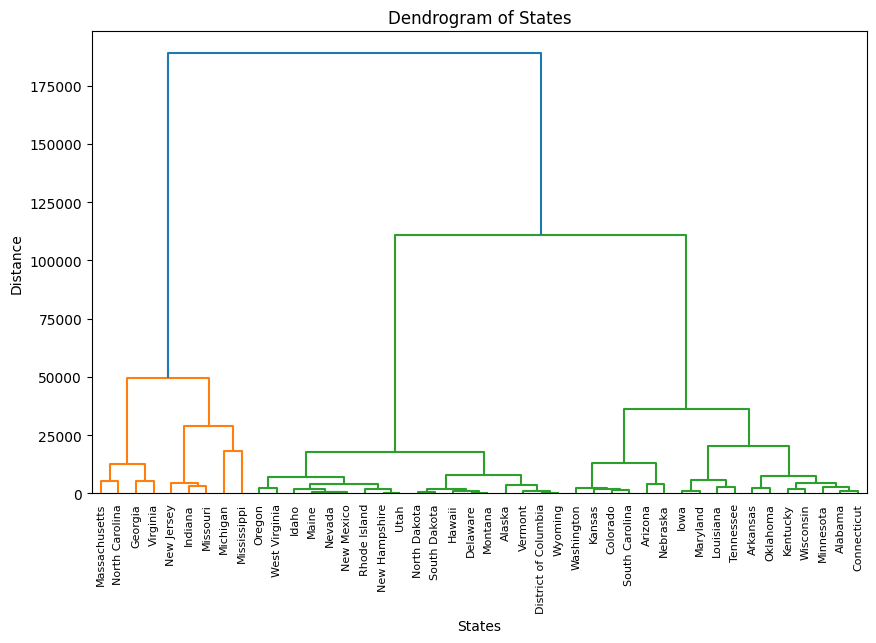

In [13]:
#standardizing the data
Z = linkage(new_df, method='ward')


plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df['State'].values)
plt.xlabel('States')
plt.ylabel('Distance')
plt.title('Dendrogram of States')
plt.show()

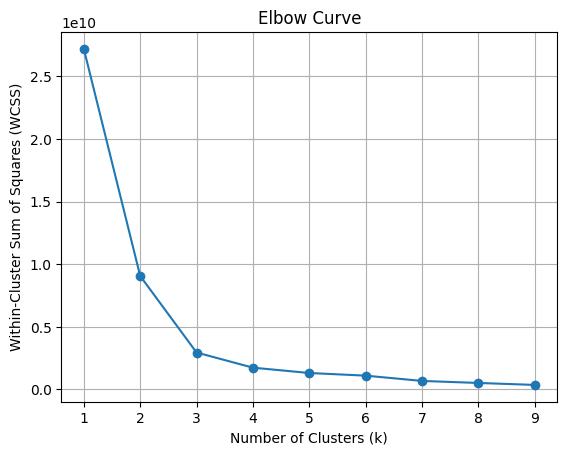

In [14]:
#hierarchical clustering using Ward's method - 4 clusters
wcss = []
 
k_values = range(1, 10)
 
#k-means clustering
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_df)
    wcss.append(kmeans.inertia_)
 
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()

In [15]:
#label defining
clusters = fcluster(Z, 4, criterion='maxclust')
cluster_states = {}
 
#connecting states to corresponding clusters
for state, cluster in zip(df['State'], clusters):
    if cluster not in cluster_states:
        cluster_states[cluster] = []
    cluster_states[cluster].append(state)
 
#display states
for cluster, states in cluster_states.items():
    print(f"Cluster {cluster}: {states}")

Cluster 4: ['Alabama', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Minnesota', 'Nebraska', 'Oklahoma', 'South Carolina', 'Tennessee', 'Washington', 'Wisconsin']
Cluster 3: ['Alaska', 'Delaware', 'District of Columbia', 'Hawaii', 'Idaho', 'Maine', 'Montana', 'Nevada', 'New Hampshire', 'New Mexico', 'North Dakota', 'Oregon', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wyoming']
Cluster 1: ['Georgia', 'Massachusetts', 'North Carolina', 'Virginia']
Cluster 2: ['Indiana', 'Michigan', 'Mississippi', 'Missouri', 'New Jersey']


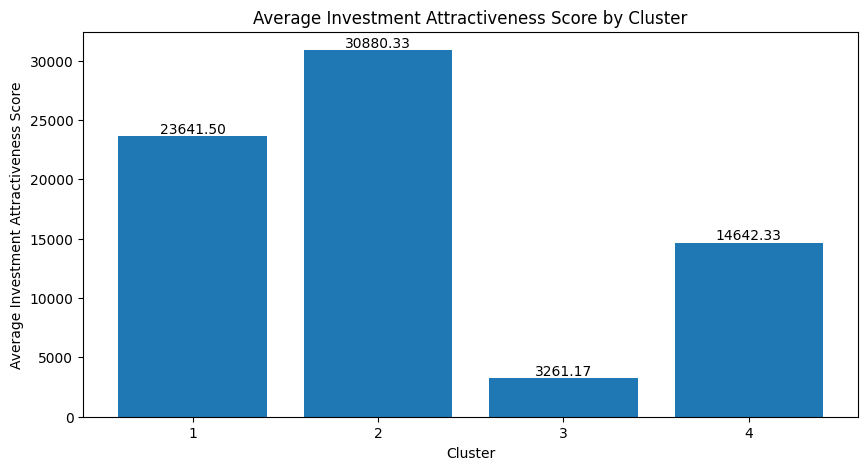

In [16]:
#average investment attractiveness score by cluster
cluster_scores = {}
 
for cluster, states in cluster_states.items():
    cluster_scores[cluster] = df[df['State'].isin(states)]['Investment_Attractiveness_Score'].median()
 
plt.figure(figsize=(10, 5))
plt.bar(cluster_scores.keys(), cluster_scores.values())
plt.xticks(list(cluster_scores.keys()))
plt.xlabel('Cluster')
plt.ylabel('Average Investment Attractiveness Score')
plt.title('Average Investment Attractiveness Score by Cluster')
 
#display score
for cluster, score in cluster_scores.items():
    plt.text(cluster, score, f'{score:.2f}', ha='center', va='bottom')
 
plt.show()

In [18]:
closest_states = {}
 
for cluster, states in cluster_states.items():
    cluster_data = df[df['State'].isin(states)]
    cluster_median = cluster_data['Investment_Attractiveness_Score'].median()
    closest_state = cluster_data.iloc[(cluster_data['Investment_Attractiveness_Score'] - cluster_median).abs().argsort()[:1]]['State'].values[0]
    closest_states[cluster] = closest_state
 
closest_states

{4: 'Connecticut', 3: 'Idaho', 1: 'Massachusetts', 2: 'New Jersey'}